### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

from textwrap import wrap

import seaborn as sns

### Loading the data

In [4]:
official_names = ['Benzyl_benzoate', 'm Anisaldehyde']

In [5]:
mix = np.loadtxt(os.getcwd()+'/1H_manisaldehyde_benzylbenzoate_DMSO.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 2, 4],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [6]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [7]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [8]:
mix = Spectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


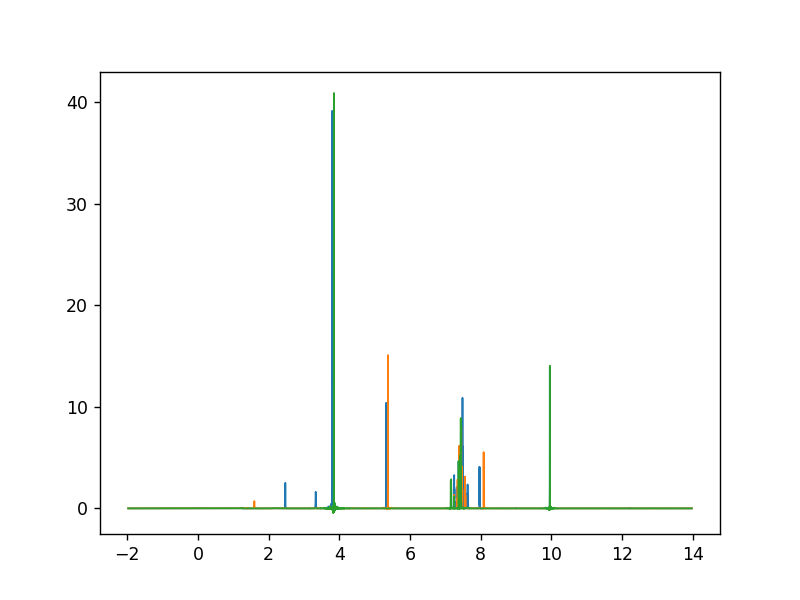

In [9]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Ground truth

In [10]:
protons = [12, 8]
molar_proportions = [0.3702, 0.6298]
molar_proportions

[0.3702, 0.6298]

In [11]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]
real_visible_proportions

[0.468568053328833, 0.5314319466711671]

### Alignment

In [12]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

In [13]:
# shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
# mix = shift_one_spectrum(mix, -0.1)

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
spectra_and_mixture = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [27]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [28]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


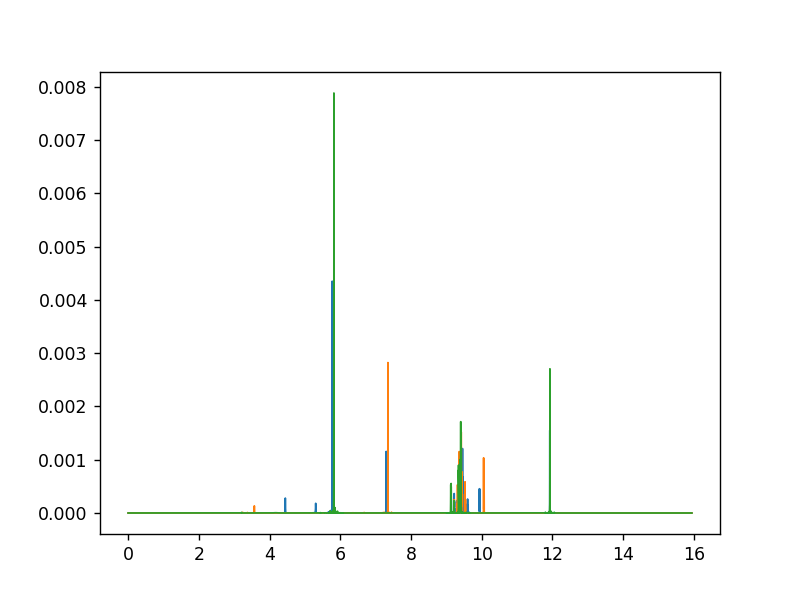

In [29]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Removing unnecessary data points

In [30]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [31]:
#3.5, 12
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 3.5, 12)

In [32]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [33]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [34]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [35]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [36]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [37]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


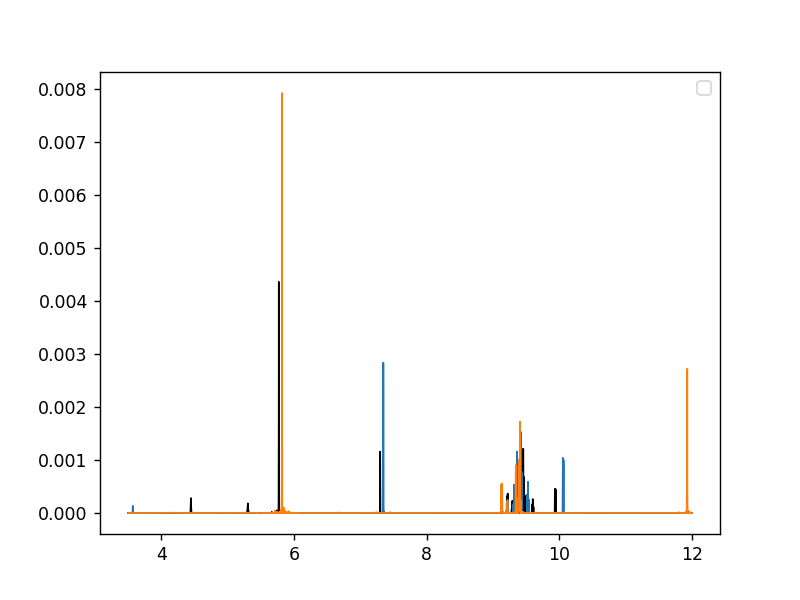

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [38]:
fig, ax = plt.subplots()
#fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
ax.legend()

### Finding best kappa

In [39]:
import time
import pandas as pd
import pulp

In [41]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [42]:
list_of_estimation_results = []
for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
    fixed_kappa = []
    for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
        start = time.time()
        estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
        end = time.time()
        fixed_kappa.append(estimation['proportions'])
        print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
        print('It took: '+str(end-start)+' seconds.')
        print(estimation['proportions'])
    list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3471159.29it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:28<00:00, 208.37s/it]


Estimation for 0.01 and 0.01 done
It took: 208.53008222579956 seconds.
[0.26161890715899927, 0.2613460118679993]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3407476.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:34<00:00, 334.77s/it]


Estimation for 0.01 and 0.02 done
It took: 334.92277097702026 seconds.
[0.04767412502099987, 0.009842105601999974]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 139577it [00:00, 3415448.52it/s]
Deconvolving chunks:   0%|                                | 0/1 [02:02<?, ?it/s]


TypeError: type NoneType doesn't define __round__ method

In [44]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [45]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [41]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [42]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [43]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [44]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


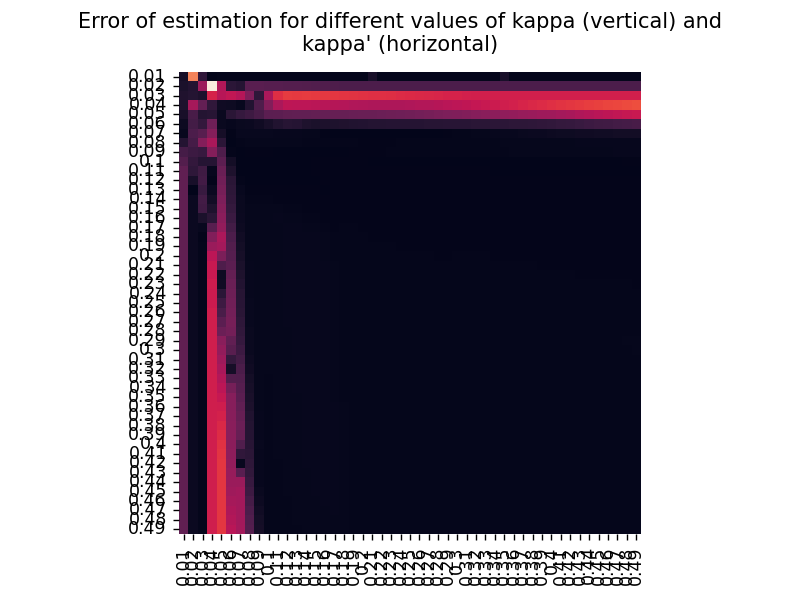

In [45]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()

sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=True)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

#### Visible proportions

In [46]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [47]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [48]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


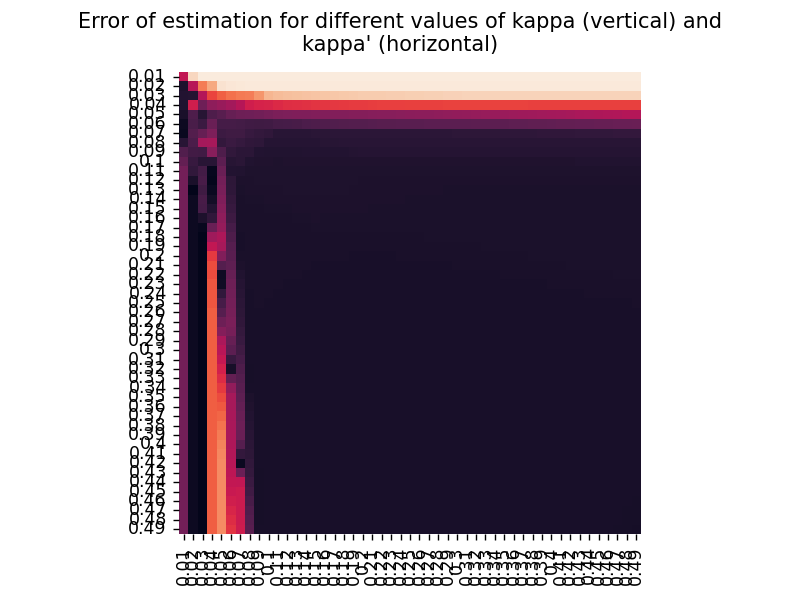

In [49]:
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]

vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()

sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

#### Both

In [50]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [51]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [52]:
all_components_results_both.min().min()

0.004972192615631976

In [53]:
all_components_results_both[0.02][0.13]

0.004972192615631976

<IPython.core.display.Javascript object>


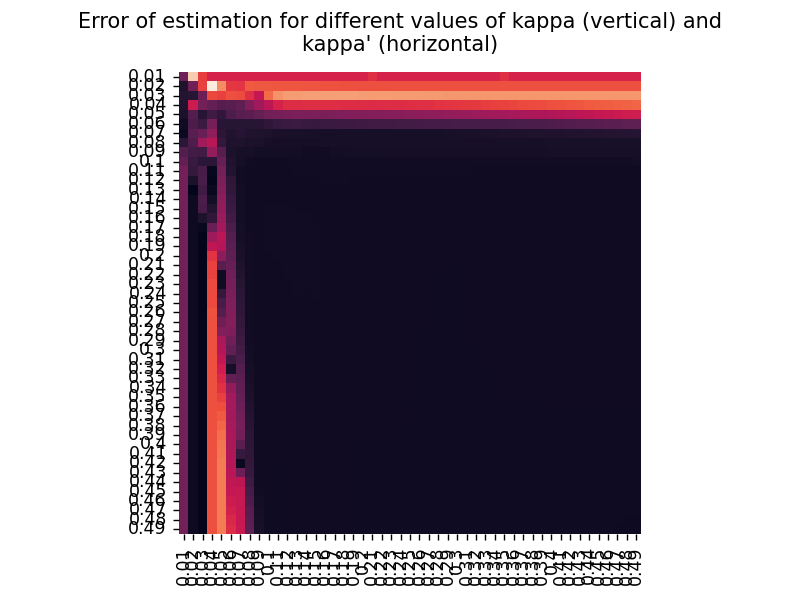

/tmp/ipykernel_7651/2090031754.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [54]:
vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

sns.heatmap(all_components_results_both.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax = fig.add_axes([.91, .3, .03, .4])
)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

### Estimation with best kappa

In [55]:
estimation = estimate_proportions(mix, [comp0, comp1], 
                                   MTD=0.13, MTD_th=0.02, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 57.76it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(3.5000299999999998, 11.99995, 0), (3.5000299999999998, 11.99995, 1)]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 8019.70it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(3.37003, 12.129950000000001)]


Splitting the experimental spectrum into chunks: 139577it [00:00, 3455465.20it/s]


Ion currents in chunks: [0.9999999999999973]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 558307 rows, 139580 columns and 1349168 nonzeros
Model fingerprint: 0x6107178a
Coefficient statistics:
  Matrix range     [2e-12, 1e+00]
  Objective range  [2e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [2e-05, 1e-01]
Presolve removed 10422 rows and 0 columns (presolve time = 5s) ...
Presolve removed 25950 rows and 0 columns (presolve time = 10s) ...
Presolve removed 33336 rows and 0 columns (presolve time = 15s) ...
Presolve removed 38516 rows and 0 columns (presolve time = 20s) ...
Presolve removed 165574 rows and 0 columns
Presolve time: 95.82s
Presolved: 139580 rows, 558306 columns, 1349167 nonzeros

Concurrent LP opt

    3527 DPushes remaining with DInf 1.2593750e-04               382s
    3320 DPushes remaining with DInf 1.2593750e-04               399s
    3113 DPushes remaining with DInf 1.2593750e-04               416s
    2906 DPushes remaining with DInf 1.2593750e-04               433s
    2699 DPushes remaining with DInf 1.2593750e-04               451s
    2492 DPushes remaining with DInf 1.2593750e-04               468s
    2285 DPushes remaining with DInf 1.2593750e-04               486s
    2078 DPushes remaining with DInf 1.2593750e-04               503s
    1871 DPushes remaining with DInf 1.2593750e-04               521s
    1664 DPushes remaining with DInf 1.2593750e-04               538s
    1457 DPushes remaining with DInf 1.2593750e-04               556s
    1250 DPushes remaining with DInf 1.2593750e-04               573s
    1043 DPushes remaining with DInf 1.2593750e-04               590s
     836 DPushes remaining with DInf 1.2593750e-04               607s
     629 DPushes rem

Deconvolving chunks: 100%|███████████████████████| 1/1 [11:39<00:00, 699.53s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9998677946429999
Noise proportion in experimental spectrum: 0.00013220535900000007
Total explanation: 1.000000000002
Noise proportion in combination of theoretical spectra: 0.992582990536


In [56]:
estimation['proportion_of_noise_in_theoretical']

0.9925829905359973

In [64]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.4697875006109987, 0.5300802940319985]

In [65]:
1-sum(estimated_visible_proportions)

0.00013220535700275704

In [66]:
real_visible_proportions

[0.468568053328833, 0.5314319466711671]

In [67]:
estimated_molar_proportions = [prop/prot for prop, prot in zip(estimated_visible_proportions, protons)]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.3714005463471488, 0.6285994536528512]

In [68]:
molar_proportions

[0.3702, 0.6298]

### Visualisation of our estimation

In [69]:
p = estimated_visible_proportions

In [70]:
p = np.array(p).reshape(len(p),1)

In [71]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [72]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [73]:
X = np.concatenate(components_ints, axis=1)

In [74]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


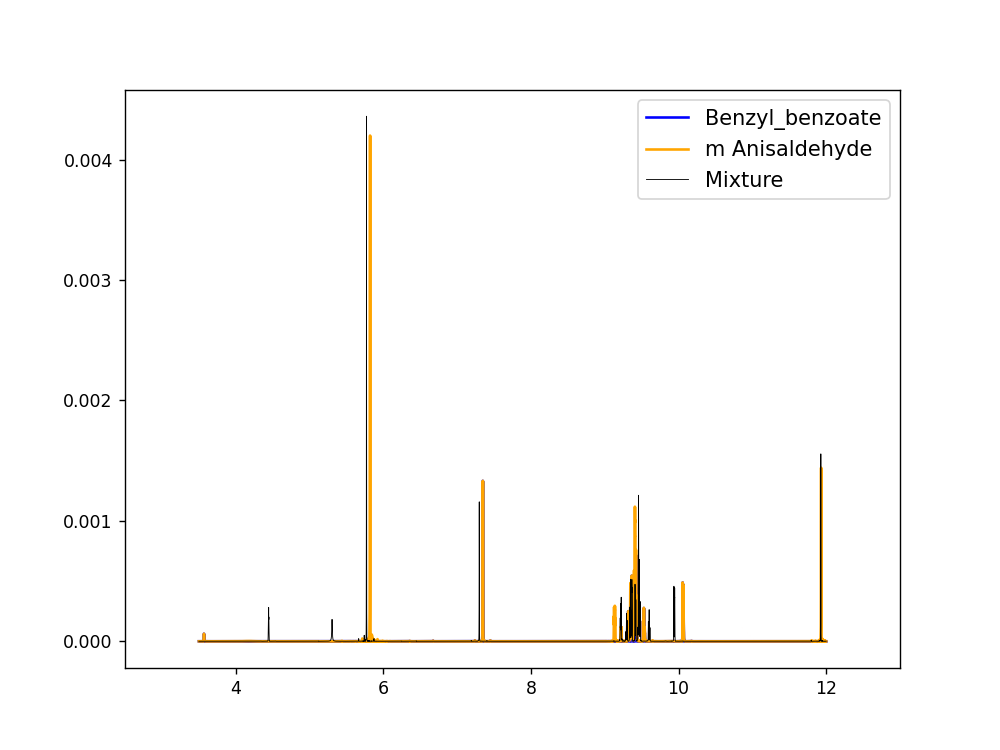

In [76]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
ax.set_xlim(2.5, 13)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})